## FINGER KUCKLE POINT AND FINGER VEIN RECOGNITION

## Importing Required Libraries

In [20]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.resnet50 import ResNet50
from keras.models import Model, save_model
from keras.preprocessing.image import img_to_array
from sklearn.model_selection import train_test_split


## Loading the Finger Knuckle Point Image Dataset

In [21]:
# Function to load finger knuckle point dataset
def load_knuckle_dataset(knuckle_folder_path):
    knuckle_images = []
    for root, dirs, files in os.walk(knuckle_folder_path):
        for file in files:
            if file.endswith(".bmp"):
                knuckle_images.append(cv2.imread(os.path.join(root, file), cv2.IMREAD_GRAYSCALE))
    return knuckle_images

## Funtion To preprocess finger knuckle point images

In [22]:
# Function to preprocess finger knuckle point images
def preprocess_knuckle_images(images):
    preprocessed_images = []
    for img in images:
        if img is None:
            continue

        # Check if the image contains the whole finger
        if img.shape[0] == 709 and img.shape[1] == 298:
            # Extract the knuckle region of interest (ROI)
            knuckle_img = img[300:450, 50:250]  # Adjust these values based on actual knuckle ROI
        else:
            knuckle_img = img
        
        # Apply preprocessing steps to the knuckle region of interest
        # Apply Gaussian blur to smooth the image
        img_blur = cv2.GaussianBlur(knuckle_img, (5, 5), 0)
        # Apply adaptive histogram equalization to enhance contrast
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        img_clahe = clahe.apply(img_blur)
        # Apply contrast stretching
        min_val = np.min(img_clahe)
        max_val = np.max(img_clahe)
        img_stretched = (img_clahe - min_val) * (255 / (max_val - min_val))
        # Convert image to uint8
        img_stretched = np.uint8(img_stretched)
        # Apply morphological operations to enhance features
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
        img_morph = cv2.morphologyEx(img_stretched, cv2.MORPH_CLOSE, kernel)
        preprocessed_images.append(img_morph)
    
    return preprocessed_images

## Function to load finger vein dataset

In [23]:
# Function to load finger vein dataset
def load_vein_dataset(vein_folder_path):
    vein_images = []
    for root, dirs, files in os.walk(vein_folder_path):
        for file in files:
            if file.endswith(".bmp"):
                vein_images.append(cv2.imread(os.path.join(root, file), cv2.IMREAD_GRAYSCALE))
    return vein_images

## Function to preprocess finger vein images

In [24]:
# Function to preprocess finger vein images
def preprocess_vein_images(images):
    preprocessed_images = []
    for idx, img in enumerate(images):
        if img is None:
            print(f"Skipping image {idx} as it is None.")
            continue

        # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization) for enhancing contrast
        clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(8, 8))
        img_clahe = clahe.apply(img)
        
        # Apply bilateral filtering for noise reduction while preserving edges
        img_bilateral = cv2.bilateralFilter(img_clahe, 9, 75, 75)
        
        # Apply Gaussian smoothing
        img_gaussian = cv2.GaussianBlur(img_bilateral, (5, 5), 0)
        
        # Apply adaptive thresholding to remove background outliers
        img_threshold = cv2.adaptiveThreshold(img_gaussian, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
        
        # Invert the binary image
        img_threshold = cv2.bitwise_not(img_threshold)
        
        # Apply morphological operations to further refine veins
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
        img_morph = cv2.morphologyEx(img_threshold, cv2.MORPH_CLOSE, kernel, iterations=5)
        
        # Apply sharpening filter to enhance vein visibility
        sharpening_kernel = np.array([[-1, -1, -1], 
                                      [-1, 9, -1], 
                                      [-1, -1, -1]])
        img_sharpened = cv2.filter2D(img_morph, -1, sharpening_kernel)
        
        # Apply Canny edge detection
        edges = cv2.Canny(img_sharpened, threshold1=50, threshold2=150)
        
        # Combine the edges with the sharpened image to enhance visibility
        preprocessed_image = cv2.addWeighted(img_sharpened, 0.8, edges, 0.2, 0)
        
        # Optional: Increase contrast and brightness
        alpha = 1.5  # Contrast control (1.0-3.0)
        beta = 30    # Brightness control (0-100)
        preprocessed_image = cv2.convertScaleAbs(preprocessed_image, alpha=alpha, beta=beta)
        
        # Invert colors to make veins dark and background white
        preprocessed_image = cv2.bitwise_not(preprocessed_image)
        
        preprocessed_images.append(preprocessed_image)
    return preprocessed_images


## Paths to the datasets

In [25]:
# Paths to the datasets
knuckle_folder_path = "C:/Users/ankit/Downloads/PolyUKnuckleV1/PolyUKnuckleV1"
vein_folder_path = "C:/Users/ankit/Downloads/FingerVein/Original"


## Load the datasets

In [26]:
# Load the datasets
knuckle_images = load_knuckle_dataset(knuckle_folder_path)
vein_images = load_vein_dataset(vein_folder_path)


## Split data into train and test sets before preprocessing

In [27]:
# Split data into train and test sets before preprocessing
knuckle_train_images, knuckle_test_images = train_test_split(knuckle_images, test_size=0.2, random_state=42)
vein_train_images, vein_test_images = train_test_split(vein_images, test_size=0.2, random_state=42)


## Preprocess the images

In [28]:
# Preprocess the images
preprocessed_knuckle_train_images = preprocess_knuckle_images(knuckle_train_images)
preprocessed_knuckle_test_images = preprocess_knuckle_images(knuckle_test_images)
preprocessed_vein_train_images = preprocess_vein_images(vein_train_images)
preprocessed_vein_test_images = preprocess_vein_images(vein_test_images)

Skipping image 247 as it is None.


In [29]:
import matplotlib.pyplot as plt

def display_images(images, title, num_samples=5):
    if len(images) == 0:
        print(f"No {title.lower()} images found in the dataset.")
        return
    
    num_samples = min(num_samples, len(images))
    fig, axs = plt.subplots(1, num_samples, figsize=(25, 10))
    for i in range(num_samples):
        axs[i].imshow(images[i], cmap='gray')
        axs[i].axis('off')
        axs[i].set_title(f'{title} {i+1}')
    plt.suptitle(f'Sample {title} Images')
    plt.show()


## Display sample knuckle images before and after preprocessing

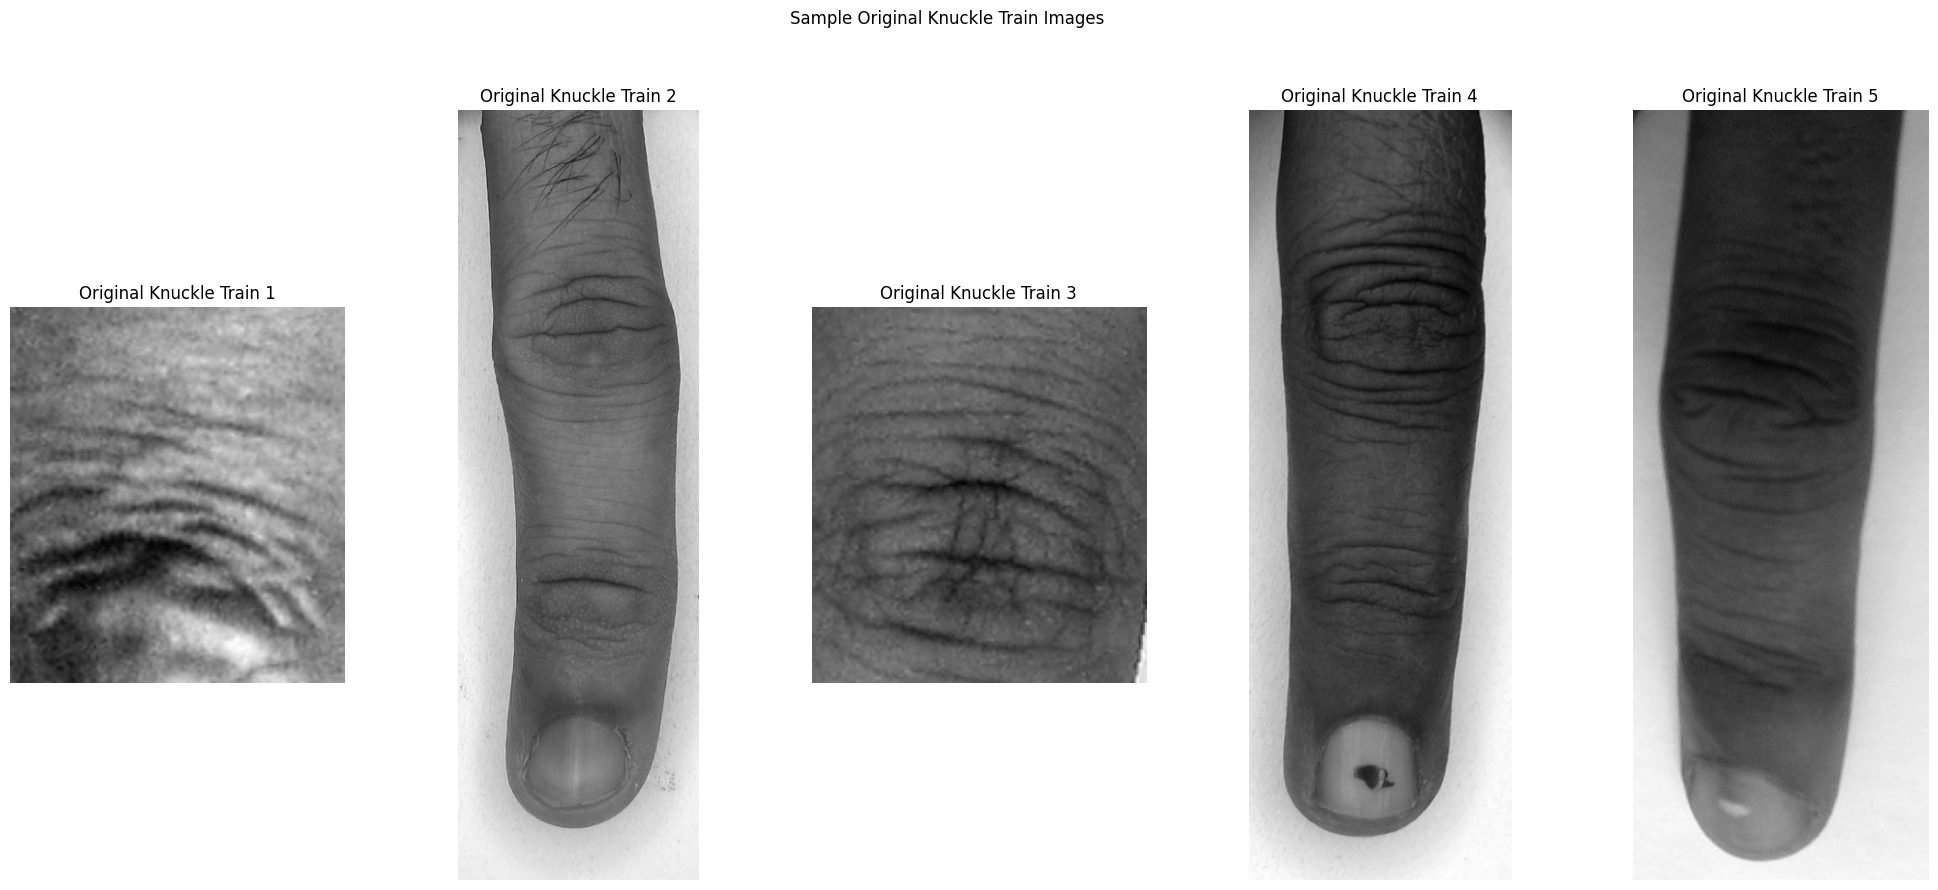

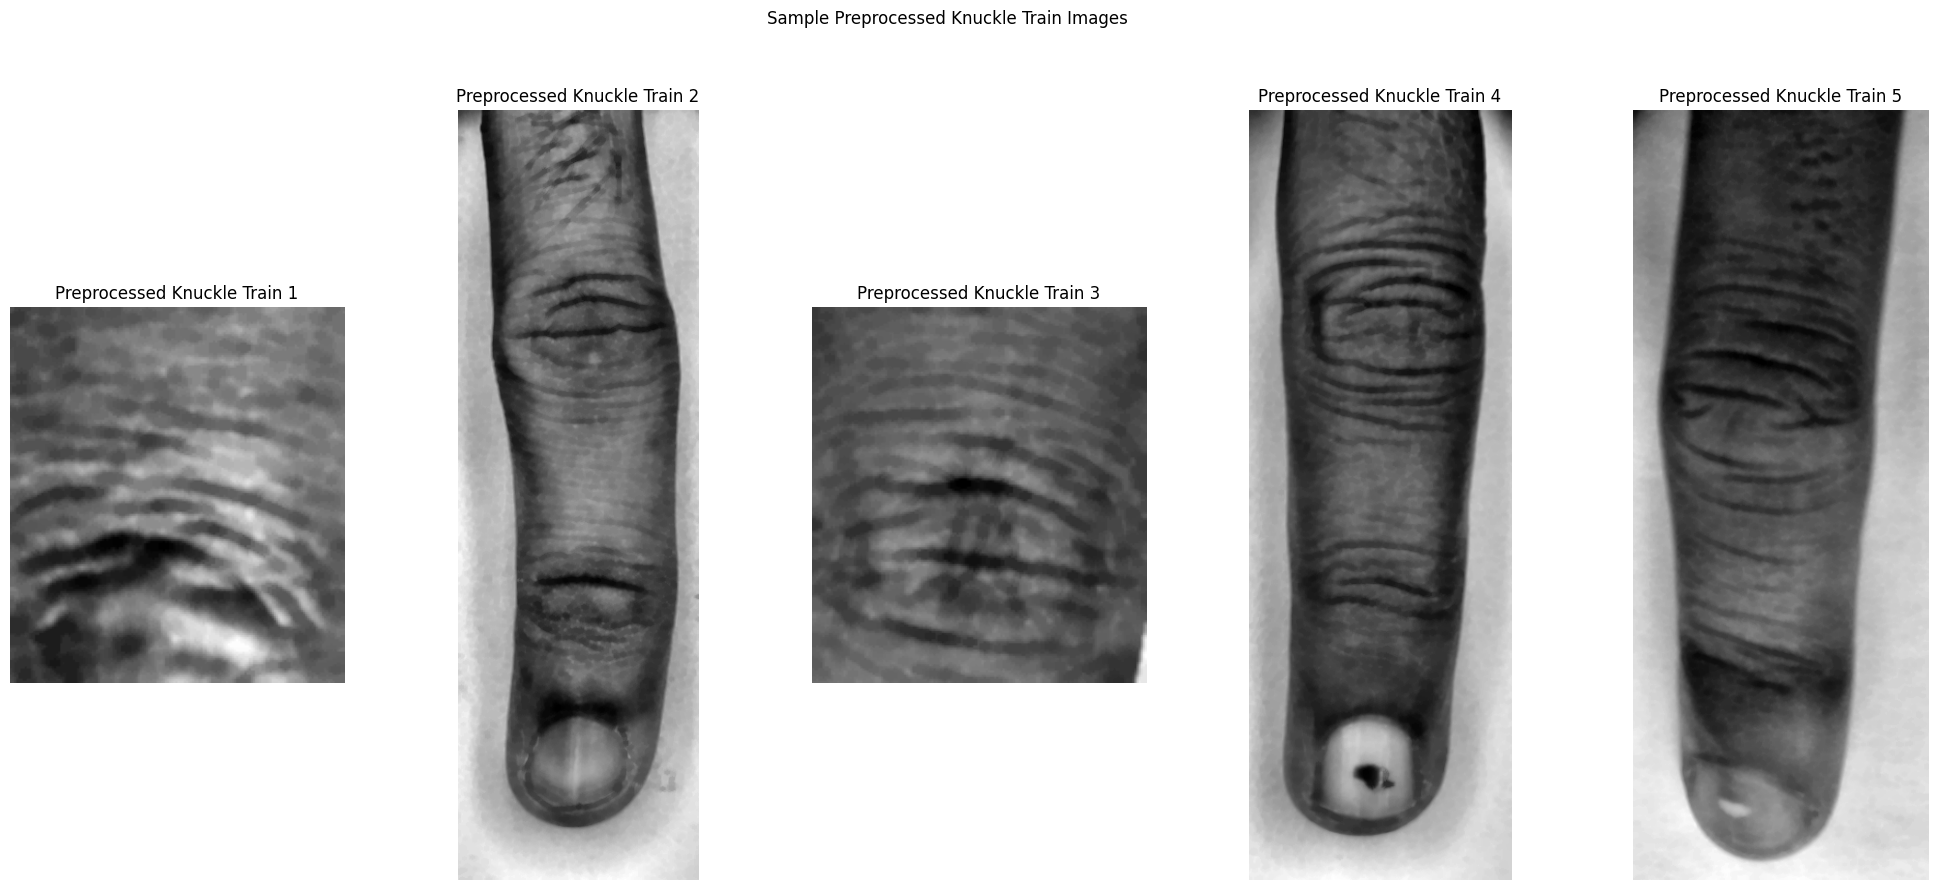

In [30]:
# Display sample knuckle images before and after preprocessing
display_images(knuckle_train_images[:5], "Original Knuckle Train")
display_images(preprocessed_knuckle_train_images[:5], "Preprocessed Knuckle Train")

## Display sample vein images before and after preprocessing

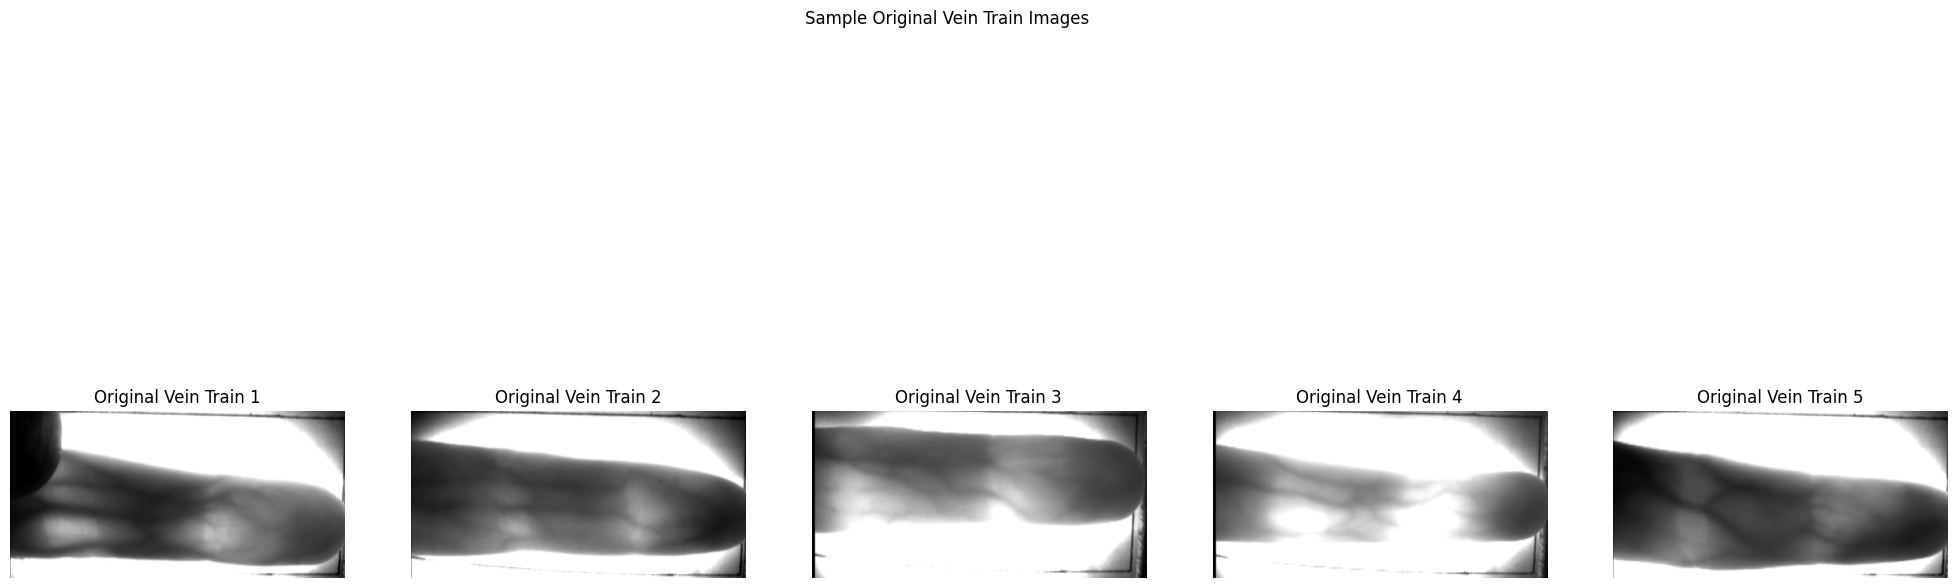

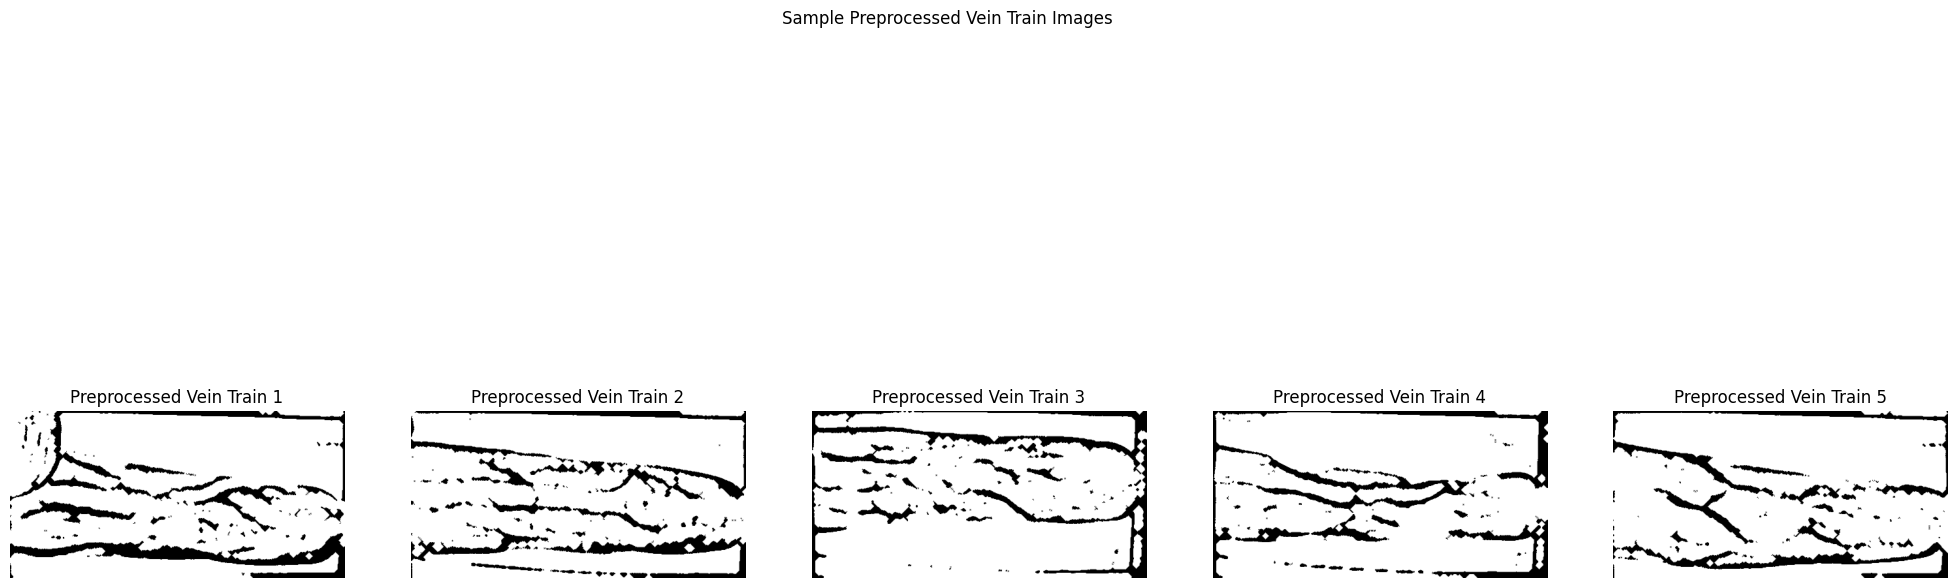

In [31]:
# Display sample vein images before and after preprocessing
display_images(vein_train_images[:5], "Original Vein Train")
display_images(preprocessed_vein_train_images[:5], "Preprocessed Vein Train")

## Creating and Compiling a Model of ResNet50 and VGG16

## Feature Extraction using various Transfer Learning

In [32]:
from keras.applications import ResNet50, VGG16
from keras.layers import GlobalAveragePooling2D
from keras.models import Model
from keras.applications.imagenet_utils import preprocess_input


def load_model_with_finetuning(base_model, target_size):
    base_model = base_model(weights='imagenet', include_top=False, input_shape=(target_size[0], target_size[1], 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    model = Model(inputs=base_model.input, outputs=x)
    return model

def preprocess_images(images, target_size):
    processed_images = []
    for img in images:
        img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)  # Convert grayscale to RGB
        img_resized = cv2.resize(img_rgb, target_size)  # Resize to target size
        processed_images.append(img_resized)
    return np.array(processed_images)




## Check the length of the Arrays

In [33]:
# Check the length of the arrays
print(len(preprocessed_knuckle_train_images))
print(len(preprocessed_vein_train_images))


6028
646


## Feature Extraction using  Resnet50

In [16]:
import os
import cv2
import numpy as np
from keras.applications import ResNet50, VGG16
from keras.applications.imagenet_utils import preprocess_input
from keras.preprocessing.image import ImageDataGenerator, img_to_array
from keras.models import Model
from keras.layers import GlobalAveragePooling2D
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity

def load_images_from_directory(directory):
    """
    Load images from the specified directory.
    Args:
        directory (str): Path to the directory containing images.
    Returns:
        list: List of loaded images.
    """
    images = []
    for filename in os.listdir(directory):
        if filename.endswith(".bmp") or filename.endswith(".png"):
            img_path = os.path.join(directory, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                images.append(img)
            else:
                print(f"Warning: Failed to load image {img_path}")
    return images

def preprocess_knuckle_images(images, target_size):
    """
    Preprocess knuckle images by cropping the region of interest (ROI) and resizing.
    Args:
        images (list): List of images to be preprocessed.
        target_size (tuple): Target size for resizing (width, height).
    Returns:
        np.array: Array of preprocessed images.
    """
    processed_images = []
    for img in images:
        # Assuming the knuckle ROI based on specific dimensions
        if img.shape[0] >= 709 and img.shape[1] >= 298:
            knuckle_roi = img[150:558, 40:338]  # Adjust these coordinates as necessary
        else:
            knuckle_roi = img
        img_rgb = cv2.cvtColor(knuckle_roi, cv2.COLOR_GRAY2RGB)
        img_resized = cv2.resize(img_rgb, target_size)
        processed_images.append(img_resized)
    return np.array(processed_images)

def preprocess_vein_images(images, target_size):
    """
    Preprocess vein images by resizing.
    Args:
        images (list): List of images to be preprocessed.
        target_size (tuple): Target size for resizing (width, height).
    Returns:
        np.array: Array of preprocessed images.
    """
    processed_images = []
    for img in images:
        if img is not None:
            img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
            img_resized = cv2.resize(img_rgb, target_size)
            processed_images.append(img_resized)
        else:
            print("Warning: Encountered an empty image")
    return np.array(processed_images)

def extract_features(images, model, preprocess_input):
    """
    Extract features from images using a pre-trained model.
    Args:
        images (np.array): Array of preprocessed images.
        model (keras.Model): Pre-trained model for feature extraction.
        preprocess_input (function): Function to preprocess input images for the model.
    Returns:
        np.array: Extracted features.
    """
    features = []
    for img in images:
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)
        feature = model.predict(img_array)
        features.append(feature.flatten())
    return np.array(features)

def load_model_with_finetuning(model_name, target_size):
    """
    Load a pre-trained model with fine-tuning.
    Args:
        model_name (str): Name of the model to load ('ResNet50' or 'VGG16').
        target_size (tuple): Input size for the model.
    Returns:
        keras.Model: Model with fine-tuning.
    """
    if model_name == 'ResNet50':
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(target_size[0], target_size[1], 3))
    elif model_name == 'VGG16':
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=(target_size[0], target_size[1], 3))
    else:
        raise ValueError("Invalid model name. Choose 'ResNet50' or 'VGG16'.")
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    model = Model(inputs=base_model.input, outputs=x)
    return model

def augment_data(images, batch_size=32):
    """
    Augment data to increase model robustness.
    Args:
        images (np.array): Array of preprocessed images.
        batch_size (int): Batch size for augmentation.
    Returns:
        np.array: Array of augmented images.
    """
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    augmented_images = []
    for batch in datagen.flow(images, batch_size=batch_size, shuffle=False):
        augmented_images.extend(batch)
        if len(augmented_images) >= len(images):
            break
    return np.array(augmented_images[:len(images)])

def match_and_fuse_features(knuckle_features, vein_features):
    """
    Match and fuse features from knuckle and vein images.
    Args:
        knuckle_features (np.array): Extracted knuckle features.
        vein_features (np.array): Extracted vein features.
    Returns:
        np.array: Fused similarity scores.
    """
    similarity_scores = cosine_similarity(knuckle_features, vein_features)
    fused_scores = np.mean(similarity_scores, axis=1)  # Fusing by averaging similarity scores
    return fused_scores

# Paths to the image directories
knuckle_folder_path = "C:/Users/ankit/Downloads/PolyUKnuckleV1/PolyUKnuckleV1"  # Update this path
vein_folder_path = "C:/Users/ankit/Downloads/FingerVein/Original"              # Update this path

# Load images
knuckle_images = load_knuckle_dataset(knuckle_folder_path)
vein_images = load_vein_dataset(vein_folder_path)

# Check if images are loaded correctly
print(f"Number of knuckle images loaded: {len(knuckle_images)}")
print(f"Number of vein images loaded: {len(vein_images)}")

if len(knuckle_images) == 0 or len(vein_images) == 0:
    raise ValueError("No images were loaded. Please check the directory paths and ensure they contain the correct image files.")

# Split the data into training and testing sets
knuckle_train_images, knuckle_test_images = train_test_split(knuckle_images, test_size=0.2, random_state=42)
vein_train_images, vein_test_images = train_test_split(vein_images, test_size=0.2, random_state=42)

# Preprocess the images
preprocessed_knuckle_train_images = preprocess_knuckle_images(knuckle_train_images, target_size=(224, 224))
preprocessed_knuckle_test_images = preprocess_knuckle_images(knuckle_test_images, target_size=(224, 224))
preprocessed_vein_train_images = preprocess_vein_images(vein_train_images, target_size=(224, 224))
preprocessed_vein_test_images = preprocess_vein_images(vein_test_images, target_size=(224, 224))

# Data augmentation for increased model robustness (training images only)
augmented_knuckle_train_images = augment_data(preprocessed_knuckle_train_images)
augmented_vein_train_images = augment_data(preprocessed_vein_train_images)

# Load pre-trained models with fine-tuning
model_name = 'ResNet50'  # Change to 'VGG16' to use VGG16 instead
model = load_model_with_finetuning(model_name, target_size=(224, 224))

# Extract features from preprocessed training images
knuckle_train_features = extract_features(augmented_knuckle_train_images, model, preprocess_input)
vein_train_features = extract_features(augmented_vein_train_images, model, preprocess_input)

# Extract features from preprocessed test images
knuckle_test_features = extract_features(preprocessed_knuckle_test_images, model, preprocess_input)
vein_test_features = extract_features(preprocessed_vein_test_images, model, preprocess_input)

print(f'Knuckle {model_name} train features shape: {knuckle_train_features.shape}')
print(f'Vein {model_name} train features shape: {vein_train_features.shape}')
print(f'Knuckle {model_name} test features shape: {knuckle_test_features.shape}')
print(f'Vein {model_name} test features shape: {vein_test_features.shape}')

# Match and fuse features for train and test sets
train_fused_scores = match_and_fuse_features(knuckle_train_features, vein_train_features)
test_fused_scores = match_and_fuse_features(knuckle_test_features, vein_test_features)

print(f'{model_name} fused train scores shape: {train_fused_scores.shape}')
print(f'{model_name} fused test scores shape: {test_fused_scores.shape}')

# Placeholder for hyperparameter tuning
# Example: tuning learning rate, batch size, epochs, optimizer, etc.
# You can implement your hyperparameter tuning logic here, using libraries such as Keras Tuner, Optuna, or manual grid search.


Number of knuckle images loaded: 7535
Number of vein images loaded: 809
1/1 [==============================] - 0s 340ms/step
Knuckle ResNet50 train features shape: (6028, 2048)
Vein ResNet50 train features shape: (646, 2048)
Knuckle ResNet50 test features shape: (1507, 2048)
Vein ResNet50 test features shape: (162, 2048)
ResNet50 fused train scores shape: (6028,)
ResNet50 fused test scores shape: (1507,)


## Calculating the Similarity Scores and Making A Decision 

In [20]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Assuming these variables contain the extracted features
# Replace these with the actual feature arrays you have
knuckle_train_features = knuckle_train_features
vein_train_features = vein_train_features
knuckle_test_features = knuckle_test_features
vein_test_features = vein_test_features

# Compute similarity scores using cosine similarity
def compute_similarity_scores(knuckle_features, vein_features):
    similarity_scores = []
    for k_feature, v_feature in zip(knuckle_features, vein_features):
        score = cosine_similarity([k_feature], [v_feature])[0][0]
        similarity_scores.append(score)
    return np.array(similarity_scores)

# Compute similarity scores for training and testing sets
train_similarity_scores = compute_similarity_scores(knuckle_train_features, vein_train_features)
test_similarity_scores = compute_similarity_scores(knuckle_test_features, vein_test_features)

# Decision making based on similarity scores
def make_decision(similarity_scores, threshold=0.5):
    decisions = ['Genuine' if score >= threshold else 'Rejected' for score in similarity_scores]
    return decisions

# Set a threshold for decision making
threshold = 0.5

# Make decisions for training and testing sets
train_decisions = make_decision(train_similarity_scores, threshold)
test_decisions = make_decision(test_similarity_scores, threshold)

# Print the results
print("Training Similarity Scores:")
print(train_similarity_scores)
print("Training Decisions:")
print(train_decisions)

print("Testing Similarity Scores:")
print(test_similarity_scores)
print("Testing Decisions:")
print(test_decisions)

# Print summary of results
print(f"Number of Genuine users in training set: {train_decisions.count('Genuine')}")
print(f"Number of Rejected users in training set: {train_decisions.count('Rejected')}")
print(f"Number of Genuine users in testing set: {test_decisions.count('Genuine')}")
print(f"Number of Rejected users in testing set: {test_decisions.count('Rejected')}")

# Additional Metrics (Optional)
def compute_additional_metrics(similarity_scores, threshold):
    genuine_scores = [score for score in similarity_scores if score >= threshold]
    rejected_scores = [score for score in similarity_scores if score < threshold]
    mean_genuine_score = np.mean(genuine_scores) if genuine_scores else 0
    mean_rejected_score = np.mean(rejected_scores) if rejected_scores else 0
    return mean_genuine_score, mean_rejected_score

mean_genuine_train_score, mean_rejected_train_score = compute_additional_metrics(train_similarity_scores, threshold)
mean_genuine_test_score, mean_rejected_test_score = compute_additional_metrics(test_similarity_scores, threshold)

print(f"Mean Genuine Train Score: {mean_genuine_train_score}")
print(f"Mean Rejected Train Score: {mean_rejected_train_score}")
print(f"Mean Genuine Test Score: {mean_genuine_test_score}")
print(f"Mean Rejected Test Score: {mean_rejected_test_score}")


Training Similarity Scores:
[0.42104876 0.43341246 0.3326071  0.38370803 0.43184978 0.4204389
 0.48032606 0.3205835  0.36098158 0.58756006 0.29325426 0.36514485
 0.27430552 0.48308963 0.40002453 0.46871698 0.5000031  0.37924027
 0.35574296 0.3700821  0.45421788 0.52894557 0.47783586 0.42584625
 0.3884316  0.47339955 0.49506876 0.44549447 0.46018097 0.42652002
 0.41871083 0.38117927 0.3802362  0.3460412  0.3344073  0.510887
 0.38278767 0.3945552  0.43440086 0.49423558 0.3380975  0.25499776
 0.4726416  0.4653346  0.38178504 0.48071364 0.2811955  0.34918606
 0.40974528 0.34446853 0.5613118  0.41139147 0.45166242 0.4183975
 0.44299775 0.37680793 0.42459995 0.46957275 0.3762475  0.42205715
 0.5178542  0.34561372 0.47017914 0.45201203 0.32126248 0.43230605
 0.3507375  0.4789668  0.34864885 0.3265922  0.39546537 0.40205178
 0.40548307 0.37866843 0.42809734 0.53568065 0.4351471  0.40351397
 0.41108605 0.42277604 0.4309977  0.4378797  0.4605922  0.44330594
 0.4431393  0.37357292 0.4634209  0.39

## Calculating the Similarity Index and Making a Decision

In [34]:
import os
import cv2
import numpy as np
from keras.applications import ResNet50, VGG16
from keras.applications.imagenet_utils import preprocess_input
from keras.preprocessing.image import ImageDataGenerator, img_to_array
from keras.models import Model
from keras.layers import GlobalAveragePooling2D
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity

def load_images_from_directory(directory):
    """
    Load images from the specified directory.
    Args:
        directory (str): Path to the directory containing images.
    Returns:
        list: List of loaded images.
    """
    images = []
    for filename in os.listdir(directory):
        if filename.endswith(".bmp") or filename.endswith(".png"):
            img_path = os.path.join(directory, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                images.append(img)
            else:
                print(f"Warning: Failed to load image {img_path}")
    return images

def preprocess_knuckle_images(images, target_size):
    """
    Preprocess knuckle images by cropping the region of interest (ROI) and resizing.
    Args:
        images (list): List of images to be preprocessed.
        target_size (tuple): Target size for resizing (width, height).
    Returns:
        np.array: Array of preprocessed images.
    """
    processed_images = []
    for img in images:
        # Assuming the knuckle ROI based on specific dimensions
        if img.shape[0] >= 709 and img.shape[1] >= 298:
            knuckle_roi = img[150:558, 40:338]  # Adjust these coordinates as necessary
        else:
            knuckle_roi = img
        img_rgb = cv2.cvtColor(knuckle_roi, cv2.COLOR_GRAY2RGB)
        img_resized = cv2.resize(img_rgb, target_size)
        processed_images.append(img_resized)
    return np.array(processed_images)

def preprocess_vein_images(images, target_size):
    """
    Preprocess vein images by resizing.
    Args:
        images (list): List of images to be preprocessed.
        target_size (tuple): Target size for resizing (width, height).
    Returns:
        np.array: Array of preprocessed images.
    """
    processed_images = []
    for img in images:
        if img is not None:
            img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
            img_resized = cv2.resize(img_rgb, target_size)
            processed_images.append(img_resized)
        else:
            print("Warning: Encountered an empty image")
    return np.array(processed_images)

def extract_features(images, model, preprocess_input):
    """
    Extract features from images using a pre-trained model.
    Args:
        images (np.array): Array of preprocessed images.
        model (keras.Model): Pre-trained model for feature extraction.
        preprocess_input (function): Function to preprocess input images for the model.
    Returns:
        np.array: Extracted features.
    """
    features = []
    for img in images:
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)
        feature = model.predict(img_array)
        features.append(feature.flatten())
    return np.array(features)

def load_model_with_finetuning(model_name, target_size):
    """
    Load a pre-trained model with fine-tuning.
    Args:
        model_name (str): Name of the model to load ('ResNet50' or 'VGG16').
        target_size (tuple): Input size for the model.
    Returns:
        keras.Model: Model with fine-tuning.
    """
    if model_name == 'ResNet50':
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(target_size[0], target_size[1], 3))
    elif model_name == 'VGG16':
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=(target_size[0], target_size[1], 3))
    else:
        raise ValueError("Invalid model name. Choose 'ResNet50' or 'VGG16'.")
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    model = Model(inputs=base_model.input, outputs=x)
    return model

def augment_data(images, batch_size=32):
    """
    Augment data to increase model robustness.
    Args:
        images (np.array): Array of preprocessed images.
        batch_size (int): Batch size for augmentation.
    Returns:
        np.array: Array of augmented images.
    """
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    augmented_images = []
    for batch in datagen.flow(images, batch_size=batch_size, shuffle=False):
        augmented_images.extend(batch)
        if len(augmented_images) >= len(images):
            break
    return np.array(augmented_images[:len(images)])

def match_and_fuse_features(knuckle_features, vein_features):
    """
    Match and fuse features from knuckle and vein images.
    Args:
        knuckle_features (np.array): Extracted knuckle features.
        vein_features (np.array): Extracted vein features.
    Returns:
        np.array: Fused similarity scores.
    """
    similarity_scores = cosine_similarity(knuckle_features, vein_features)
    fused_scores = np.mean(similarity_scores, axis=1)  # Fusing by averaging similarity scores
    return fused_scores

# Paths to the image directories
knuckle_folder_path = "C:/Users/ankit/Downloads/PolyUKnuckleV1/PolyUKnuckleV1"  # Update this path
vein_folder_path = "C:/Users/ankit/Downloads/FingerVein/Original"              # Update this path

# Load images
knuckle_images = load_knuckle_dataset(knuckle_folder_path)
vein_images = load_vein_dataset(vein_folder_path)

# Check if images are loaded correctly
print(f"Number of knuckle images loaded: {len(knuckle_images)}")
print(f"Number of vein images loaded: {len(vein_images)}")

if len(knuckle_images) == 0 or len(vein_images) == 0:
    raise ValueError("No images were loaded. Please check the directory paths and ensure they contain the correct image files.")

# Split the data into training and testing sets
knuckle_train_images, knuckle_test_images = train_test_split(knuckle_images, test_size=0.2, random_state=42)
vein_train_images, vein_test_images = train_test_split(vein_images, test_size=0.2, random_state=42)

# Preprocess the images
preprocessed_knuckle_train_images = preprocess_knuckle_images(knuckle_train_images, target_size=(224, 224))
preprocessed_knuckle_test_images = preprocess_knuckle_images(knuckle_test_images, target_size=(224, 224))
preprocessed_vein_train_images = preprocess_vein_images(vein_train_images, target_size=(224, 224))
preprocessed_vein_test_images = preprocess_vein_images(vein_test_images, target_size=(224, 224))

# Data augmentation for increased model robustness (training images only)
augmented_knuckle_train_images = augment_data(preprocessed_knuckle_train_images)
augmented_vein_train_images = augment_data(preprocessed_vein_train_images)

# Load pre-trained models with fine-tuning
model_name = 'VGG16'  # Change to 'VGG16' to use VGG16 instead
model = load_model_with_finetuning(model_name, target_size=(224, 224))

# Extract features from preprocessed training images
knuckle_train_features = extract_features(augmented_knuckle_train_images, model, preprocess_input)
vein_train_features = extract_features(augmented_vein_train_images, model, preprocess_input)

# Extract features from preprocessed test images
knuckle_test_features = extract_features(preprocessed_knuckle_test_images, model, preprocess_input)
vein_test_features = extract_features(preprocessed_vein_test_images, model, preprocess_input)

print(f'Knuckle {model_name} train features shape: {knuckle_train_features.shape}')
print(f'Vein {model_name} train features shape: {vein_train_features.shape}')
print(f'Knuckle {model_name} test features shape: {knuckle_test_features.shape}')
print(f'Vein {model_name} test features shape: {vein_test_features.shape}')

# Match and fuse features for train and test sets
train_fused_scores = match_and_fuse_features(knuckle_train_features, vein_train_features)
test_fused_scores = match_and_fuse_features(knuckle_test_features, vein_test_features)

print(f'{model_name} fused train scores shape: {train_fused_scores.shape}')
print(f'{model_name} fused test scores shape: {test_fused_scores.shape}')

# Placeholder for hyperparameter tuning
# Example: tuning learning rate, batch size, epochs, optimizer, etc.
# You can implement your hyperparameter tuning logic here, using libraries such as Keras Tuner, Optuna, or manual grid search.


Number of knuckle images loaded: 7535
Number of vein images loaded: 809
1/1 [==============================] - 0s 292ms/step
Knuckle VGG16 train features shape: (6028, 512)
Vein VGG16 train features shape: (646, 512)
Knuckle VGG16 test features shape: (1507, 512)
Vein VGG16 test features shape: (162, 512)
VGG16 fused train scores shape: (6028,)
VGG16 fused test scores shape: (1507,)


In [35]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Assuming these variables contain the extracted features
# Replace these with the actual feature arrays you have
knuckle_train_features = knuckle_train_features
vein_train_features = vein_train_features
knuckle_test_features = knuckle_test_features
vein_test_features = vein_test_features

# Compute similarity scores using cosine similarity
def compute_similarity_scores(knuckle_features, vein_features):
    similarity_scores = []
    for k_feature, v_feature in zip(knuckle_features, vein_features):
        score = cosine_similarity([k_feature], [v_feature])[0][0]
        similarity_scores.append(score)
    return np.array(similarity_scores)

# Compute similarity scores for training and testing sets
train_similarity_scores = compute_similarity_scores(knuckle_train_features, vein_train_features)
test_similarity_scores = compute_similarity_scores(knuckle_test_features, vein_test_features)

# Decision making based on similarity scores
def make_decision(similarity_scores, threshold=0.5):
    decisions = ['Genuine' if score >= threshold else 'Rejected' for score in similarity_scores]
    return decisions

# Set a threshold for decision making
threshold = 0.5

# Make decisions for training and testing sets
train_decisions = make_decision(train_similarity_scores, threshold)
test_decisions = make_decision(test_similarity_scores, threshold)

# Print the results
print("Training Similarity Scores:")
print(train_similarity_scores)
print("Training Decisions:")
print(train_decisions)

print("Testing Similarity Scores:")
print(test_similarity_scores)
print("Testing Decisions:")
print(test_decisions)

# Print summary of results
print(f"Number of Genuine users in training set: {train_decisions.count('Genuine')}")
print(f"Number of Rejected users in training set: {train_decisions.count('Rejected')}")
print(f"Number of Genuine users in testing set: {test_decisions.count('Genuine')}")
print(f"Number of Rejected users in testing set: {test_decisions.count('Rejected')}")

# Additional Metrics (Optional)
def compute_additional_metrics(similarity_scores, threshold):
    genuine_scores = [score for score in similarity_scores if score >= threshold]
    rejected_scores = [score for score in similarity_scores if score < threshold]
    mean_genuine_score = np.mean(genuine_scores) if genuine_scores else 0
    mean_rejected_score = np.mean(rejected_scores) if rejected_scores else 0
    return mean_genuine_score, mean_rejected_score

mean_genuine_train_score, mean_rejected_train_score = compute_additional_metrics(train_similarity_scores, threshold)
mean_genuine_test_score, mean_rejected_test_score = compute_additional_metrics(test_similarity_scores, threshold)

print(f"Mean Genuine Train Score: {mean_genuine_train_score}")
print(f"Mean Rejected Train Score: {mean_rejected_train_score}")
print(f"Mean Genuine Test Score: {mean_genuine_test_score}")
print(f"Mean Rejected Test Score: {mean_rejected_test_score}")


Training Similarity Scores:
[0.37376353 0.44550365 0.4114799  0.48974994 0.45762312 0.36792207
 0.31644744 0.29713583 0.34082782 0.38407722 0.38308543 0.4262423
 0.3697912  0.29161412 0.39361852 0.4128173  0.45224702 0.34616947
 0.34692186 0.3531766  0.36602116 0.39899427 0.4231305  0.417567
 0.30732912 0.50138414 0.36712226 0.49807677 0.4859403  0.4572428
 0.39693362 0.44598177 0.44020376 0.36282554 0.37335694 0.4537683
 0.5377901  0.2589141  0.34323877 0.435017   0.33996153 0.35674495
 0.37815335 0.43520904 0.44096243 0.5543105  0.37698787 0.5596832
 0.36864176 0.32470658 0.42255878 0.4210425  0.39431524 0.4581342
 0.49571505 0.25360146 0.44500217 0.51122814 0.2772743  0.26536942
 0.4070473  0.34278813 0.46293795 0.36750555 0.31858632 0.42862907
 0.3055417  0.5023247  0.49630684 0.34067094 0.32158887 0.30286512
 0.3754251  0.39713687 0.39204174 0.4228884  0.5008974  0.36707646
 0.48208517 0.48503977 0.4986323  0.28195924 0.42126346 0.31071892
 0.3965375  0.35582075 0.46640337 0.38466